In [ ]:
http://api.indeed.com/ads/apisearch?publisher=942007812079380&q=data+science&v=2&limit=25&start=0

In [24]:
import pandas as pd
import requests
import lxml.html
from lxml.html.clean import Cleaner
import re
#import json
from time import sleep
from random import randint
import csv


def parse_main_page(query='data+science', pages=1):

    base_url = 'http://api.indeed.com/ads/apisearch?publisher=942007812079380&q='
    page_url = '&v=2&limit=25&start='
    headers = {'User-agent':'Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9.0.1) Gecko/2008071615 Fedora/3.0.1-1.fc9 Firefox/3.0.1'}
    
    main_results = []


    try:
        for n in range(1, pages+1):

            #random time delay for scraping
            sleep(randint(0,2))

            url = ''.join([base_url, query, page_url, str(n*25-25)])

            print('Processing main page %s of %s %s' % (str(n), str(pages), url))

            #random time delay for scraping
            sleep(randint(0,5))

            #r = requests.get(url, headers=headers)
            r = requests.get(url)

            doc = lxml.html.fromstring(r.content)
            
            listings = doc.cssselect('results result')

            for listing in listings:
                dat = {}

                # request status
                dat['index_url'] = url
                dat['status_code'] = r.status_code

                # title
                dat['job_title'] = listing.cssselect('jobtitle')[0].text.strip()
                dat['company'] = listing.cssselect('company')[0].text.strip()
                dat['city'] = listing.cssselect('city')[0].text.strip()
                dat['state'] = listing.cssselect('state')[0].text.strip()
                dat['country'] = listing.cssselect('country')[0].text.strip()
                dat['location'] = ''.join([dat['city'],', ',dat['state'],' ',dat['country']])

                # posted date
                dat['post_date'] = listing.cssselect('date')[0].text.strip()
                dat['expired'] = listing.cssselect('expired')[0].text.strip()

                #dat['views'] = re.compile('\((\d*)\sviews\)').findall(doc.cssselect('p.submission-date')[0].text_content().replace(',',''))[0]

                # body
                dat['summary'] = listing.cssselect('snippet')[0].text.strip()
                dat['listing_url'] = listing.cssselect('url')[0].text.strip()
                
                # get additional information from listing page
                dat = parse_listing_page(dat)

                main_results.append(dat)
            
    except:
        print('This page did not return results: %s ' % url)

    print('Done processing main page')
    return main_results

def parse_listing_page(dat):
    
    headers = {'User-agent':'Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9.0.1) Gecko/2008071615 Fedora/3.0.1-1.fc9 Firefox/3.0.1'}

    try:
        
        #random time delay for scraping
        sleep(randint(0,2))

        url = dat['listing_url']
        print('Processing listing page %s' % url)

        r = requests.get(url, headers=headers)
        
        doc = lxml.html.fromstring(r.content)

        
        #dat['listing_status'] = r.status_code
        #print(r.status_code)
        
        #<span class="slNoUnderline">10,735 reviews</span>
        #if doc.cssselect('span.slNoUnderline'):
        #    dat['views'] = re.compile('(\d*)\sreviews').findall(doc.cssselect('span.slNoUnderline')[0].text_content().replace(',',''))[0]
        
        # body
        #<span id="job_summary" class="summary">
        dat['body'] = doc.cssselect('#job_summary')[0].text_content()


    except:
        print('Error getting listing details for: %s' % url)
    
    return dat



if __name__ == '__main__':
    
    #get results
    listings = parse_main_page(query='data+science', pages=4)
    
    df = pd.DataFrame.from_dict(listings, dtype=None)
    
    print(df.head())

    #create filename
    #filename = location.replace('--', '_').replace('-', '_').lower() + '.csv'
    filename = 'indeed-job-listings.csv'
    
    #get all keys
    headings = sorted(list(set().union(*(d.keys() for d in listings))))
    
    #write to csv file
    with open(filename, 'w') as output_file:
        dict_writer = csv.DictWriter(output_file, headings)
        dict_writer.writeheader()
        dict_writer.writerows(listings)



Processing main page 1 of 4 http://api.indeed.com/ads/apisearch?publisher=942007812079380&q=data+science&v=2&limit=25&start=0
Processing listing page http://www.indeed.com/viewjob?jk=7e8fe748424511c9&qd=uJ0wQTSmQs0yu93par7Vd6qsCLZX8EX93urv426uJCn2NYlaC_XI9FB45ks3WkXvbrxeSLObihrK5ht2SLqcgrW3UIhx0VVoZ5YxUNOd4EI&indpubnum=942007812079380&atk=1ahcspq495sv0fa7
Processing listing page http://www.indeed.com/viewjob?jk=4332542420d6bd52&qd=uJ0wQTSmQs0yu93par7Vd6qsCLZX8EX93urv426uJCn2NYlaC_XI9FB45ks3WkXvbrxeSLObihrK5ht2SLqcgrW3UIhx0VVoZ5YxUNOd4EI&indpubnum=942007812079380&atk=1ahcspq495sv0fa7
Processing listing page http://www.indeed.com/viewjob?jk=5df3246825de10f5&qd=uJ0wQTSmQs0yu93par7Vd6qsCLZX8EX93urv426uJCn2NYlaC_XI9FB45ks3WkXvbrxeSLObihrK5ht2SLqcgrW3UIhx0VVoZ5YxUNOd4EI&indpubnum=942007812079380&atk=1ahcspq495sv0fa7
Processing listing page http://www.indeed.com/viewjob?jk=ba266f8cb3fa7a4b&qd=uJ0wQTSmQs0yu93par7Vd6qsCLZX8EX93urv426uJCn2NYlaC_XI9FB45ks3WkXvbrxeSLObihrK5ht2SLqcgrW3UIhx0VVoZ5YxU

In [25]:
from collections import Counter
import string

df = df.dropna()

def remove_punctuation(s):
    
    # using string lib and translate
    bad_chars = '.,;'
    return s.translate(string.maketrans("", "", ), bad_chars)

def tokenize(s):
    """return a list of lowercased tokens (words) in a string without punctuation
    """
    #using split and lower
    #remove_punctuation(s).lower().split()
    return s.lower().split()

def word_count(s):
    """count the number of times each word (lowercased) appears and return a dictionary
    """
    # get individual words
    # count original list and loop through
    
    # alternate: in list, for element i, count identical to end, remove identical, move to next
    
    # final choice, use counter
    words = tokenize(s)
    
    #print()
    #print(Counter(words).most_common(100))
    
    return Counter(words).most_common(1000)


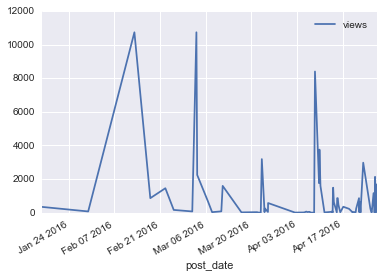

In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

df.views = df.views.astype('int')
df.post_date = pd.to_datetime(df['post_date'])

df.plot(x='post_date', y='views')

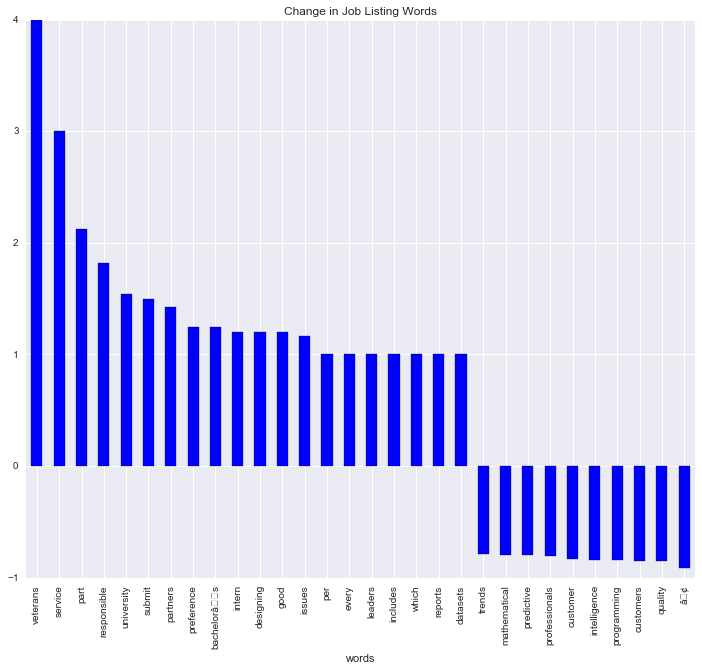

In [27]:
early = ''
later = ''

import string

# Create a dictionary using a comprehension - this maps every character from
# string.punctuation to None. Initialize a translation object from it.
translator = str.maketrans({key: None for key in string.punctuation})

# s = 'string with "punctuation" inside of it! Does this work? I hope so.'

# # pass the translator to the string's translate method.
# print(s.translate(translator))

df = df.sort_values('post_date')

for body in df['body'][0:50]:
    body = body.translate(translator)
    early = ''.join([str(early), str(body)])
    
for body in df['body'][51:99]:
    body = body.translate(translator)
    later = ''.join([str(later), str(body)])
    
df_early = pd.DataFrame(word_count(early), columns=['words', 'early'])
df_later = pd.DataFrame(word_count(later), columns=['words', 'later'])

df_words = df_early.merge(df_later)
df_words['change'] = (df_words.later - df_words.early)/df_words.early
df_words = df_words.set_index('words')


df_trends = df_words.sort_values('change', ascending=False)[0:20].append(df_words.sort_values('change')[0:10]).sort_values('change', ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=1)
df_trends.change.plot(kind='bar', ax=axes, figsize=(12, 10), title='Change in Job Listing Words')
plt.savefig('word_frequency_change.png', bbox_inches='tight')

In [37]:
df_words.head(200)

,early,later,change
words,,,
and,1508,968,-0.358090
to,745,584,-0.216107
the,678,656,-0.032448
of,593,548,-0.075885
data,546,275,-0.496337
in,488,321,-0.342213
a,460,296,-0.356522
with,367,246,-0.329700
or,321,167,-0.479751


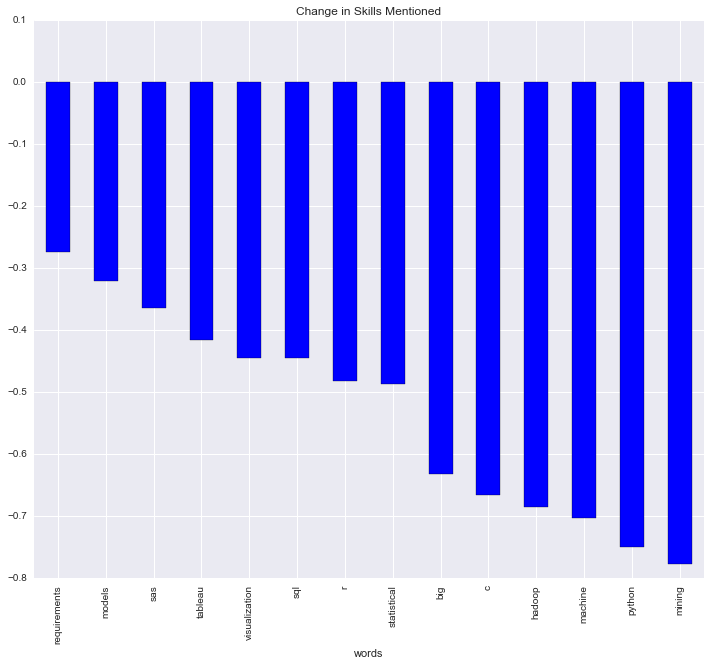

In [29]:
skills = ['aws', 'ab', 'neural', 'sql', 'tableau', 'scala', 'r', 'python', 'algorythms', 'requirements', 'machine', 'statistical', 'models', 'big', 'mining', 'sas', 'visualization', 'hadoop', 'c', 'excel', 'cloud', 'hive', 'matlab', 'spss']

# with pd.option_context('display.max_rows', 999, 'display.max_columns', 3):
#     print(df_words)

#len(skills)

df_skills = df_words[df_words.index.isin(skills)].sort_values('change', ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=1)
df_skills.change.plot(kind='bar', ax=axes, figsize=(12, 10), title='Change in Skills Mentioned')
plt.savefig('skills_frequency_change.png', bbox_inches='tight')

In [28]:
df.company.value_counts()[0:20]

Booz Allen Hamilton                        5
KPMG                                       3
U.S. Federal Government                    3
IBM                                        2
National Security Agency                   2
KEYW Corporation                           2
National Geospatial-Intelligence Agency    2
Cisco Systems, Inc.                        2
Aol                                        2
The Advisory Board Company                 2
Morgan Lewis                               2
USAA                                       2
TransVoyant                                2
Intel                                      2
DigitalGlobe                               2
World Wildlife Fund                        2
General Dynamics Mission Systems           1
Deloitte                                   1
University of the District of Columbia     1
The Nielsen Company                        1
Name: company, dtype: int64